In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils_printable import printable



abbreviations = {"RAC1P": "RAC", "White alone": "White", "Reference person": "Ref person", \
"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions": "Empl. for-profit-c",\
"Employee of a private not-for-profit, tax-exempt, or charitable organization": "Empl. no-profit-c",
"Self-employed in own not incorporated business, professional practice, or farm": "Self-Empl. not incorp" ,     
"Self-employed in own incorporated business, professional practice or farm": "Self-Empl. incorp" ,
"Local government employee (city, county, etc.)" : "Local gov. Empl. ",
"Federal government employee": "Federal gov.  Empl.",
"California/CA":"CA", "Never married or under 15 years old": "Never married/<15yrs", 
"Biological son or daughter": "Son/daughter", "Regular high school diploma":"HS", \
"Asian alone":"Asian", "1 or more years of college credit":"1+ collage cr",
"Some Other Race alone": "Other", "Bachelor's degree": "Bachelor", "Master's degree": "Master", 
                "Some college, but less than 1 year": "<1y collage",
                "Associate's degree":"Associate",
"Noninstitutionalized group quarters population": "Noninstit. GQs", 
"OCCP=CMM-Software Developers": "OCCP=CMM-SW Dev", 
                 "Professional degree beyond a bachelor's degree": "Prof beyond bachelor"}

In [3]:
def printable_with_ratio(df_pr, abbreviations = {}, show_weighted_ratio = False):
    out_cols = ["itemsets", "sup", "Δ_outcome", "t_outcome", "ratio"]
    df_pr["ratio"] = df_pr["outcome"]/mean_outcome
    if show_weighted_ratio:
        out_cols = out_cols + ["wlogr"]
    df_pr = printable(df_pr, abbreviations=abbreviations)
    return df_pr[out_cols]



# Load data

In [4]:
from folktables import ACSDataSource, ACSIncome

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)

In [5]:
from folktables.acs import adult_filter
from folktables import BasicProblem
import numpy as np

feature_names = [
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P'
    ]

target='PINCP'

ACSIncome_outcome = BasicProblem(
    features=feature_names,
    target=target,
    #target_transform=lambda x: x > 50000,    
    group='RAC1P',
    preprocess=adult_filter,
    #postprocess=lambda x: np.nan_to_num(x, -1),
)

In [6]:
features, label, group = ACSIncome_outcome.df_to_numpy(acs_data)

In [7]:
continuous_attributes = ['AGEP', 'WKHP']

In [8]:
categorical_attributes = list(set(feature_names)-set(continuous_attributes))

In [9]:
import pandas as pd


df = pd.DataFrame(features, columns=feature_names)
df["income"] = label
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,48500.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0,7700.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0,17200.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0,12000.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0,300.0


# Remap columns

From label encoding to interpretable notation: e.g., 0, 1 to "male", "female"

In [10]:

import pandas as pd
import os
filename = os.path.join(os.path.curdir, "datasets", "ACSPUMS", "PUMS_Data_Dictionary_2018.csv")

In [11]:
df_mappings = pd.read_csv(filename)

In [12]:
remapping_cols = {}

In [13]:
orig_col = "1"
new_col = "Record Type"
cols_i = [orig_col, new_col]

#col_name = "OCCP"
for col_name in categorical_attributes:
    dict_i = df_mappings.loc["VAL"].loc[col_name][cols_i].set_index(orig_col).to_dict()[new_col]
    dict_i = {float(k) if (k not in ["b", "bb", 'bbb', 'bbbb']) else -1 :v for k,v in dict_i.items()}
    remapping_cols[col_name] = dict_i

In [14]:
from copy import deepcopy

df_renamed = deepcopy(df)

for column_name in remapping_cols:
    df_renamed[column_name] = df[column_name].replace(remapping_cols[column_name])

We substituite nan with string "NaN"

In [15]:
for c in df_renamed:
    if df_renamed[c].isna().any():
        print(c)
        df_renamed[c].fillna('NaN', inplace=True)

In [16]:
df_renamed.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income
0,30.0,Self-employed in own not incorporated business...,Grade 11,Married,TRN-Cleaners Of Vehicles And Equipment,California/CA,Institutionalized group quarters population,40.0,Male,Some Other Race alone,48500.0
1,21.0,State government employee,Regular high school diploma,Never married or under 15 years old,"SCI-Other Life, Physical, And Social Science T...",California/CA,Noninstitutionalized group quarters population,20.0,Male,White alone,7700.0
2,65.0,"Employee of a private not-for-profit, tax-exem...",Master's degree,Never married or under 15 years old,CMS-Clergy,California/CA,Noninstitutionalized group quarters population,8.0,Male,White alone,17200.0
3,33.0,Employee of a private for-profit company or bu...,Grade 11,Divorced,TRN-Cleaners Of Vehicles And Equipment,New York/NY,Institutionalized group quarters population,40.0,Male,White alone,12000.0
4,18.0,"Employee of a private not-for-profit, tax-exem...","1 or more years of college credit, no degree",Never married or under 15 years old,CMM-Software Developers,California/CA,Noninstitutionalized group quarters population,18.0,Female,White alone,300.0


In [17]:
[i for i in df_renamed["OCCP"].unique() if "MGR" in i]

['MGR-Lodging Managers',
 'MGR-Food Service Managers',
 'MGR-Social And Community Service Managers',
 'MGR-Other Managers',
 'MGR-Medical And Health Services Managers',
 'MGR-Human Resources Managers',
 'MGR-Sales Managers',
 'MGR-Farmers, Ranchers, And Other Agricultural Managers',
 'MGR-Education And Childcare Administrators',
 'MGR-General And Operations Managers',
 'MGR-Training And Development Managers',
 'MGR-Chief Executives And Legislators',
 'MGR-Property, Real Estate, And Community Association Managers',
 'MGR-Marketing Managers',
 'MGR-Industrial Production Managers',
 'MGR-Construction Managers',
 'MGR-Entertainment and Recreation Managers',
 'MGR-Financial Managers',
 'MGR-Computer And Information Systems Managers',
 'MGR-Architectural And Engineering Managers',
 'MGR-Purchasing Managers',
 'MGR-Public Relations And Fundraising Managers',
 'MGR-Advertising And Promotions Managers',
 'MGR-Administrative Services Managers',
 'MGR-Transportation, Storage, And Distribution Man

In [18]:
import pickle

with open(
    os.path.join(os.path.curdir, "datasets", "ACSPUMS", "census_column_mapping.pickle"),
    "wb",
) as fp:
    pickle.dump(remapping_cols, fp)

In [19]:
from copy import deepcopy

df_analysis = deepcopy(df_renamed)

In [20]:
df_analysis.to_csv(os.path.join(os.path.curdir, "datasets", "ACSPUMS", "adult_dataset_income.csv"), index=False)

In [21]:
continuous_attributes = ['AGEP', 'WKHP']

In [22]:
df_analysis.shape

(195665, 11)

# Taxonomy

In [23]:
df_analysis_proc = deepcopy(df_analysis)

## Occupation

In [24]:
attr = "OCCP"
from copy import deepcopy

#generalization_dict_tax = deepcopy(generalization_dict)
generalization_dict_tax = {}
generalization_dict_tax[attr] = {x: x.split("-")[0] for x in df_analysis_proc[attr].values if "-" in x}

## Mean of transport

In [25]:
attr = "JWTR"

if attr in df_analysis_proc.columns:
    print(df_analysis_proc[attr].value_counts()/len(df_analysis_proc))
    generalization_dict_tax[attr] =  {'Bicycle': 'Private Transportation', 
    'Car, truck, or van': 'Private Transportation', 
    'Bus or trolley bus': 'Public Transportation',
    'Railroad': 'Public Transportation',
    'Subway or elevated': 'Public Transportation',
    'Motorcycle': 'Private Transportation', 
    'Streetcar or trolley car (carro publico in Puerto Rico)': 'Public Transportation',
    'Ferryboat': 'Public Transportation'}

## Working weeks

In [26]:
attr = "WKW"

if attr in df_analysis_proc.columns:
    print(df_analysis_proc[attr].value_counts())
    generalization_dict_tax[attr] =  {'14 to 26 weeks worked during past 12 months': '14 to 39 weeks worked during past 12 months',
    '27 to 39 weeks worked during past 12 months': '14 to 39 weeks worked during past 12 months',
    '40 to 47 weeks worked during past 12 months': '40 to 49 weeks worked during past 12 months',
    '48 to 49 weeks worked during past 12 months': '40 to 49 weeks worked during past 12 months'}

## Arrival and departure time at work

In [27]:
def taxonomy_split_in_slot(values):
    def define_slot(x, v_slot):            
            if int(x)%v_slot == 0:
                slot_value= f"{x}-{x+v_slot}"
                if x == 24:
                    slot_value= f"{x}-{v_slot}"
            else:
                x = x-(int(x)%v_slot)
                slot_value= f"{x}-{x+v_slot}"
            return slot_value
        
    tax = {}

    for val in values:
        if val=="NaN":
            continue
        tmp = val.split(":")
        h = int(tmp[0])
        t = tmp[1].split(" ")[1]
        if h==12:
            if t == "a.m.":
                h = 0    
        else:
            if t=="p.m.":
                h = h+12
        hier1 = h

        tax[val] = str(hier1)

        hier2 = define_slot(h, 2)
        tax[str(hier1)] = hier2
        hier3 = define_slot(h, 4)
        tax[hier2] = hier3
    return tax

In [28]:
attr = "JWAP"

if attr in df_analysis_proc.columns:
    tax= taxonomy_split_in_slot(df_analysis_proc[attr].unique())

    generalization_dict_tax[attr] = tax

attr = "JWDP"
if attr in df_analysis_proc.columns:
    # We use the same
    generalization_dict_tax[attr] = deepcopy(tax)

## Country

We rename some of the columns for vizualization and mapping reasons.

In [29]:
if "POBP" in df_analysis_proc.columns:
    df_analysis_proc["POBP"] = df_analysis_proc["POBP"]\
    .replace({"England":"United Kingdom", 'Scotland': "United Kingdom", \
              "United Kingdom, Not Specified": "United Kingdom",  'Northern Ireland': "United Kingdom",\
               "USSR": "Russia", "Hong Kong": "Hong Kong SAR",
             "Democratic Republic of Congo (Zaire)": 'Democratic Republic of the Congo',
             "Trinidad & Tobago": "Trinidad and Tobago", 'Macedonia':'North Macedonia',
             'Antigua & Barbuda': 'Antigua and Barbuda', \
              'Commonwealth of the Northern Mariana Islands':'Northern Mariana Islands',
             'St. Vincent & the Grenadines': 'St. Vincent and the Grenadines', \
              #simplification
             "Azores Islands": "Portugal"})

In [30]:
# https://statisticstimes.com/geography/countries-by-continents.php
df_taxonomy_country = pd.read_csv("country_hierarchies.csv", header=None, index_col=0)

df_taxonomy_country.columns=["Country or Area","ISO-alpha3 Code", "M49 Code", "Region 1", "Region 2", "Continent"]

df_taxonomy_country["Country or Area"] = df_taxonomy_country["Country or Area"].replace({
    "Viet Nam":"Vietnam", "Bolivia (Plurinational State of)": "Bolivia" ,\
      "Russian Federation": "Russia",'Iran (Islamic Republic of)': 'Iran', \
    "Lao People's Democratic Republic": "Laos", 'Syrian Arab Republic': "Syria", 
    'Venezuela (Bolivarian Republic of)': "Venezuela",
    "Republic of Moldova": "Moldova", "Czechia": "Czech Republic",
        'United Republic of Tanzania': "Tanzania", 'Côte d’Ivoire': "Ivory Coast",
        'United States Virgin Islands': 'US Virgin Islands', 'Saint Lucia': 'St. Lucia', 
    'Saint Kitts and Nevis': 'St. Kitts-Nevis',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    "United Kingdom of Great Britain and Northern Ireland" : "United Kingdom",\
    "China, Hong Kong Special Administrative Region" : "Hong Kong SAR"
})


g_hierarchy = {}
target_cols = ["Country or Area", "Region 1", "Continent"]
for i, row in df_taxonomy_country.iterrows():
    levels = [col for col in target_cols if pd.notnull(row[col])]
    
    for l in range(len(levels)-1):
        tax_c, tax_p = row[levels[l]], row[levels[l+1]]
        # If already exist but the value is different
        if "Korea" in tax_c:
            tax_c = "Korea"
        
        if tax_c in g_hierarchy and tax_p!=g_hierarchy[tax_c]:
            print(row)
            raise ValueError()
        if tax_c == tax_p:
            continue
        g_hierarchy[tax_c] = tax_p
attr = 'POBP'
#g_hierarchy = {}
g_hierarchy.update({"North America": "America", 
 "South America": "America", 
 "Americas, Not Specified" : "America", 
"Other Europe, Not Specified": "Europe",
"Eastern Africa, Not Specified": "Africa",
"Other Asia, Not Specified": "Asia",
"South Central Asia, Not Specified": "Asia",
"Caribbean, Not Specified": "North America",
"Other US Island Areas, Oceania, Not Specified, or at Sea": "Oceania",
"Other Africa, Not Specified": "Africa",
"Western Africa, Not Specified": "Africa",
                   "Taiwan" : 'Eastern Asia',
                   'Czechoslovakia':'Eastern Europe', 'Yugoslavia':'Southern Europe'})


In [31]:
generalization_dict_tax_u = deepcopy(g_hierarchy)
delete_values = []
for c, v in df_analysis_proc["POBP"].value_counts().items():
    if c not in g_hierarchy.keys():
        if "/" in c:
            g_hierarchy[c] = "United States of America"
        else:
            delete_values.append(c)

delete_values.append("North America")
delete_values.append("South America")
delete_values.append("Micronesia")

tot_deleted = 0
for c in delete_values:
    print(c, len(df_analysis_proc.loc[df_analysis_proc["POBP"]==c]))
    tot_deleted +=len(df_analysis_proc.loc[df_analysis_proc["POBP"]==c])
print(tot_deleted, round(tot_deleted/len(df_analysis_proc),5))

Asia 54
Europe 23
Africa 18
West Indies 2
North America 0
South America 4
Micronesia 8
109 0.00056


Delete rows for which the detailed information is not available

In [32]:
df_analysis_proc = df_analysis_proc.loc[df_analysis_proc["POBP"].isin(delete_values)==False]

In [33]:
df_analysis_proc.loc[df_analysis_proc["POBP"].isin(delete_values)]

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income


In [34]:
generalization_dict_tax[attr] = generalization_dict_tax_u

In [35]:
df_analysis_proc.to_csv(os.path.join(os.path.curdir, "datasets", "ACSPUMS", "adult_dataset_income_tax.csv"), index=False)

In [36]:
import json

with open(os.path.join(os.path.curdir, "datasets", "ACSPUMS", "adult_taxonomies.json"), "w") as fp:
    json.dump(generalization_dict_tax, fp)

# Tree divergence - income - individual

## min_sup_divergence = 0.025

In [37]:
all_results = {}

In [38]:
min_support_trees = [0.0025, 0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3]

In [39]:
metric = "d_outcome"


target = "income"

type_experiment = "one_at_time"

type_criterion = "weighted_sum_abs_reference_s"

In [40]:
min_sup_divergence = 0.025

In [41]:
from tree_discretization_ranking import TreeDiscretization_ranking
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence



for min_support_tree in min_support_trees:

    if min_support_tree in all_results:
        out = all_results[min_support_tree]
    else:
        out = {}
        
    print(min_support_tree, end = " ")
    
    tree_discr = TreeDiscretization_ranking()



    generalization_dict, discretizations = tree_discr.get_tree_discretization(
        df_analysis_proc,
        type_splitting=type_experiment,
        min_support=min_support_tree,
        metric=metric,
        continuous_attributes= list(continuous_attributes),
        storeTree=True,
        type_criterion = type_criterion,
        minimal_gain = 0.0,
        target_col = target
    )

    
    generalization_dict_all = deepcopy(generalization_dict)
    generalization_dict_all.update(generalization_dict_tax)
    
    from utils_extract_divergence_generalized_ranking import (
        extract_divergence_generalized,
    )

    for apply_generalization in [False, True]:
        if apply_generalization == True:
            pattern_type = "generalized"
        else:
            pattern_type = "base"

        if pattern_type in out:
            continue
            
        FP_fm = extract_divergence_generalized(
            df_analysis_proc,
            discretizations,
            generalization_dict_all,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=apply_generalization,
            target_name = target,
            FPM_type="fpgrowth",
            metrics_divergence = ["d_outcome"],
            type_experiment = type_experiment,
            allow_overalp = False if type_experiment!="all_attributes" else True
        )


        fp_divergence_o = FP_Divergence(FP_fm, metric = "d_outcome")
        out[pattern_type]  = fp_divergence_o.getDivergence(th_redundancy=0).\
                    sort_values(fp_divergence_o.metric, key = abs, ascending = False).head(1)
    all_results[min_support_tree] = out

0.0025 0.005 0.01 0.02 0.025 0.035 0.05 0.075 0.1 0.125 0.15 0.175 0.2 0.25 0.3 

In [42]:
vs = []
for min_support_tree in all_results:
    out = all_results[min_support_tree]
    for type_gen in out:
        vs.append([min_support_tree, type_gen] + list(out[type_gen].iloc[0].values))
result = pd.DataFrame(vs, columns = ["min_sup", "type_gen"] + list(out[type_gen].columns))
display(result.sort_values(["min_sup", "type_gen"]))

,min_sup,type_gen,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
0,0.0025,base,0.028790,(SCHL=Professional degree beyond a bachelor's ...,1,5630.0,170441.813499,105256.743074,46.671452
1,0.0025,generalized,0.025047,"(WKHP=>=44.0, OCCP=MGR, AGEP=>=35.0, SEX=Male)",4,4898.0,184525.279706,119340.209281,50.568105
2,0.0050,base,0.028790,(SCHL=Professional degree beyond a bachelor's ...,1,5630.0,170441.813499,105256.743074,46.671452
3,0.0050,generalized,0.025047,"(WKHP=>=44.0, OCCP=MGR, AGEP=>=35.0, SEX=Male)",4,4898.0,184525.279706,119340.209281,50.568105
4,0.0100,base,0.028790,(SCHL=Professional degree beyond a bachelor's ...,1,5630.0,170441.813499,105256.743074,46.671452
5,0.0100,generalized,0.025047,"(WKHP=>=44.0, OCCP=MGR, AGEP=>=35.0, SEX=Male)",4,4898.0,184525.279706,119340.209281,50.568105
6,0.0200,base,0.028790,(SCHL=Professional degree beyond a bachelor's ...,1,5630.0,170441.813499,105256.743074,46.671452
7,0.0200,generalized,0.025047,"(WKHP=>=44.0, OCCP=MGR, AGEP=>=35.0, SEX=Male)",4,4898.0,184525.279706,119340.209281,50.568105
8,0.0250,base,0.028790,(SCHL=Professional degree beyond a bachelor's ...,1,5630.0,170441.813499,105256.743074,46.671452
9,0.0250,generalized,0.025047,"(WKHP=>=44.0, OCCP=MGR, AGEP=>=35.0, SEX=Male)",4,4898.0,184525.279706,119340.209281,50.568105


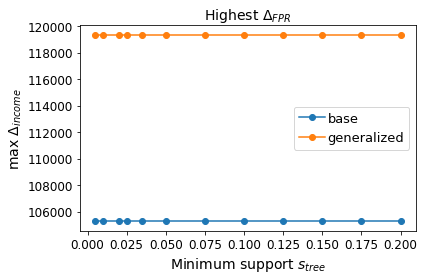

In [43]:
from pathlib import Path
outfig_dir = "0_output_figures"
Path(outfig_dir).mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt


show_sup = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]




metric_name = "d_outcome"


vs = {}


fig, ax = plt.subplots()

base = { min_support_tree: all_results[min_support_tree]["base"].iloc[0][metric_name] for min_support_tree in all_results if min_support_tree in show_sup}
gen =  { min_support_tree: all_results[min_support_tree]["generalized"].iloc[0][metric_name] for min_support_tree in all_results  if min_support_tree in show_sup}

base = dict(sorted(base.items(), key=lambda item: item[0]))
gen = dict(sorted(gen.items(), key=lambda item: item[0]))


ax.plot(list(base.keys()), list(base.values()), label = "base", marker = "o")
ax.plot(list(gen.keys()), list(gen.values()), label = "generalized", marker = "o")

ax.set_title(r"Highest Δ$_{FPR}$")


ax.set_ylabel(r"max Δ$_{income}$")
ax.set_xlabel(r"Minimum support $s_{tree}$")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ): #ax.get_xticklabels()
        item.set_fontsize(14)

for item in ax.get_xticklabels() + ax.get_yticklabels():
     item.set_fontsize(12)
        
plt.legend( fontsize = 13, handletextpad=0.2)



plt.tight_layout();
plt.savefig(f"{outfig_dir}/adult_sensitivity_s_{min_sup_divergence}.pdf");

In [47]:
round(gen[0.005]/1000, 2)

119.34

In [44]:
base

{0.005: 105256.74307427197,
 0.01: 105256.74307427197,
 0.02: 105256.74307427197,
 0.025: 105256.74307427197,
 0.035: 105256.74307427197,
 0.05: 105256.74307427197,
 0.075: 105256.74307427197,
 0.1: 105256.74307427197,
 0.125: 105256.74307427197,
 0.15: 105256.74307427197,
 0.175: 105256.74307427197,
 0.2: 105256.74307427197}